# Summary of the Code

This code performs fine-tuning, evaluation, and visualization of machine learning models for multi-label classification in a palliative care dataset. Below is a high-level overview:

---

## 1. **Fine-Tuning Models**
- **Folder Setup**:
  - Creates a folder (`results_Version_1`) to store evaluation results.
- **Model Initialization**:
  - Loops through multiple models, initializing tokenizers and classifiers for each.
  - Configures the model for multi-label classification with a number of output labels matching palliative care categories.
- **Data Preparation**:
  - Processes the training, testing, and external datasets using a `process_data` function to tokenize text and format labels.
  - Constructs `DataLoader` objects for efficient batch processing.
- **Training and Evaluation**:
  - Fine-tunes each model using a `fine_tune_model` function.
  - Evaluates loss on the test and external datasets using the `evaluate` function.
- **Metrics Calculation**:
  - Evaluates precision, recall, F1-score, and AUC for test and external datasets using the `evaluate_model` function.
  - Saves metrics as CSV files for further analysis.

---

## 2. **Visualization**
- **ROC Curves for Each Label**:
  - Generates ROC curves for each palliative care category and model using the `plot_roc_curves_for_labels` function.
  - Displays per-label performance with AUC values for all models.
- **Average ROC Curves**:
  - Calculates average ROC curves across all labels for each model using the `plot_average_roc_curves` function.
  - Interpolates TPRs at standard FPR thresholds for consistent visualization.
  - Plots the mean ROC curve for each model with its average AUC.

---

## 3. **Performance Storage**
- **Dictionaries**:
  - Stores predictions and true labels for both test and external datasets in dictionaries for each model.
- **DataFrame Conversion**:
  - Converts metrics into pandas DataFrames for tabular representation and saves them as CSV files.

---

## 4. **Overall Functionality**
- **Automation**:
  - Automates fine-tuning, evaluation, and visualization for multiple models across multiple labels.
- **Comprehensive Metrics**:
  - Calculates and stores detailed metrics, including precision, recall, F1-score, specificity, accuracy, AUC, and AUPRC.
- **Visual Insights**:
  - Provides individual and averaged ROC curves to compare model performance visually.

---

## Key Outputs
- **Metrics CSV Files**:
  - Test and external evaluation metrics for each model are saved in `results_Version_1`.
- **Visualizations**:
  - ROC curves for individual labels and averaged ROC curves across all labels for each model.
- **Console Logs**:
  - Prints training progress, loss values, and evaluation summaries for each model.


### 1. **Importing Libraries**
The code starts by importing necessary libraries for machine learning, natural language processing, and data visualization:
- `numpy` and `pandas`: For numerical and data manipulations.
- `torch`: For deep learning tasks.
- `transformers`: For pre-trained language models.
- `matplotlib`: For visualizing results like ROC and AUC curves.
- `sklearn`: For calculating evaluation metrics like confusion matrix, classification reports, and ROC curves.


In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

2024-03-29 08:16:46.929068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 08:16:49.697342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2. **Loading Data**

In [1]:
df_external = pd.read_csv('df_external.csv')
df = pd.read_csv("df.csv")

### 3. **Preprocessing**

- **Initialize Dictionaries**:
  - `test_predictions_dict` and `test_true_labels_dict`: Store predictions and true labels for the test dataset.
  - `external_predictions_dict` and `external_true_labels_dict`: Store predictions and true labels for the external validation dataset.

- **Define Palliative Care Categories**:
  - A list `pallative_cares` is created with categories like `Spiritual`, `Existential`, `Religious`, and `Values`.

- **Model Name Mapping**:
  - A dictionary `model_names` maps model identifiers to human-readable names. For example:
    - `"pallative_care_BERT"` is labeled as `"Spritual_BERT"`.

- **Set Seed for Reproducibility**:
  - `torch.manual_seed(42)` ensures consistent results by setting the random seed.

- **Split the Dataset**:
  - The main dataset (`df`) is divided into training and testing sets using an 80/20 split. The `random_state=42` ensures reproducibility.

- **Define Palliative Care Columns**:
  - `pallative_cares`: Extracts column names for palliative care categories from the main dataset.
  - `ex_pallative_cares`: Extracts similar column names from the external dataset.
  - `num_pallative_cares`: Stores the total number of palliative care categories.


In [13]:
# dictionary
test_predictions_dict = {}
test_true_labels_dict = {}
external_predictions_dict = {}
external_true_labels_dict = {}
pallative_cares=['Spiritual','Existential','Religious','Values']

# Model names with abbreviations
model_names = {
    #"bert-base-uncased": "BERT",
    #"SpanBERT/spanbert-large-cased": "SpanBERT",
    #"dmis-lab/biobert-v1.1": "BioBERT",
   # "emilyalsentzer/Bio_ClinicalBERT": "Bio-ClinicalBERT",
    #"allenai/scibert_scivocab_uncased": "SciBERT",
   # "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract": "PubMedBERT",
   # "distilbert-base-uncased": "DistilBERT",
    "pallative_care_BERT": "Spritual_BERT"
}

# Set the seed for reproducibility
torch.manual_seed(42)

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define palliative cares from the dataset columns
pallative_cares = df.columns[5:].tolist()
ex_pallative_cares = df_external.columns[2:].tolist()
num_pallative_cares = len(pallative_cares)

### 4. **Prepare Data Set for Training and Evaluation**

- **Purpose**:
  - The `process_data` function prepares a dataset for training or evaluation by tokenizing the input text, converting labels into tensors, and creating a PyTorch `TensorDataset`.

- **Inputs**:
  - `df`: The input DataFrame containing the text data and labels.
  - `pallative_cares`: A list of column names representing the target labels for palliative care categories.
  - `tokenizer`: A tokenizer object from the Hugging Face `transformers` library.
  - `max_length`: The maximum sequence length for tokenized inputs (default: 512).

- **Steps**:
  1. **Extract Texts**:
     - Converts the `Note` column from the DataFrame into a list of texts.
  2. **Process Labels**:
     - Extracts label columns specified by `pallative_cares`.
     - Converts the labels to numeric values, replacing any invalid entries with `0` using `pd.to_numeric` and `.fillna(0)`.
     - Converts the labels into a list of lists for multi-label classification.
  3. **Tokenize Texts**:
     - Tokenizes the text data with the provided `tokenizer`:
       - **Truncation** ensures that sequences longer than `max_length` are trimmed.
       - **Padding** ensures all sequences have the same length.
       - **`return_tensors="pt"`** converts the output to PyTorch tensors.
     - Extracts `input_ids` (token IDs) and `attention_mask` (indicates which tokens are padding).
  4. **Convert Labels to Tensors**:
     - Converts the processed labels into a PyTorch tensor of type `float32`.
  5. **Create a TensorDataset**:
     - Combines `input_ids`, `attention_mask`, and `labels_tensor` into a PyTorch `TensorDataset`, which is compatible with PyTorch's `DataLoader`.

- **Output**:
  - Returns a `TensorDataset` containing the tokenized inputs, attention masks, and corresponding labels.


In [ ]:
# Data processing function
def process_data(df, pallative_cares, tokenizer, max_length=512):
    texts = df['Note'].tolist()
    labels = df[pallative_cares].apply(pd.to_numeric, errors='coerce').fillna(0).values.tolist()
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=max_length)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels_tensor = torch.tensor(labels, dtype=torch.float32)
    dataset = TensorDataset(input_ids, attention_mask, labels_tensor)
    return dataset

### 5. **Evaluation Function**
- **Purpose**:
  - The `evaluate` function calculates the average loss of a model on a given dataset using a specified loss function.

- **Inputs**:
  - `model`: The PyTorch model being evaluated.
  - `data_loader`: A DataLoader object that provides batches of data for evaluation.
  - `device`: The computation device (`'cuda'` or `'cpu'`) where the model and data will be processed.
  - `loss_fct`: The loss function used to compute the discrepancy between predictions and true labels.

- **Steps**:
  1. **Set Model to Evaluation Mode**:
     - `model.eval()` ensures the model operates in evaluation mode, disabling dropout and other training-specific behavior.
  2. **Initialize Total Loss**:
     - `total_loss` is initialized to accumulate the batch-wise losses.
  3. **Iterate Through Batches**:
     - For each batch in `data_loader`:
       - The `input_ids`, `attention_mask`, and `labels` are transferred to the specified `device`.
       - The model's predictions (`logits`) are obtained using `model(input_ids, attention_mask=attention_mask)`.
       - The batch loss is calculated by comparing `logits` to `labels` using the provided `loss_fct`.
       - The batch loss is added to `total_loss`.
  4. **Compute Average Loss**:
     - The total loss is divided by the number of batches to calculate `avg_loss`.

- **Outputs**:
  - Returns the average loss (`avg_loss`) over the entire dataset provided by the DataLoader.

- **Use Case**:
  - This function is typically used to evaluate model performance on a validation or test dataset during or after training.



In [ ]:
# Evaluation function
def evaluate(model, data_loader, device, loss_fct):
    model.eval()
    total_loss = 0.0
    for batch in data_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fct(logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

### 6. **Computes Various Metrics Function**

- **Purpose**:
  - This function evaluates model performance on a dataset for multiple categories (e.g., palliative care types) and computes various metrics like precision, recall, F1-score, specificity, accuracy, AUC, and AUPRC.

---

## Steps

### 1. Set the Model to Evaluation Mode
- **`model.eval()`**: Ensures the model operates in evaluation mode, disabling dropout and other training-specific behavior.

---

### 2. Initialize Predictions and Labels
- **Dictionaries for predictions and true labels**:
  - `predictions`: Stores model predictions for each palliative care category.
  - `true_labels`: Stores ground-truth labels for each palliative care category.

---

### 3. Iterate Through the DataLoader
- For each batch in the dataset:
  - Transfer `input_ids` and `attention_mask` to the specified `device` (`'cuda'` or `'cpu'`).
  - Transfer `labels` to CPU and convert to numpy arrays.
  - Pass `input_ids` and `attention_mask` through the model to obtain logits (predictions).
  - Extract logits for each palliative care category and store them in `predictions`.
  - Store true labels for each palliative care category in `true_labels`.

---

### 4. Initialize Metrics
- A `metrics` dictionary is created to store the following metrics for each palliative care category:
  - **Precision**, **Recall**, **F1-score**, **Specificity**, **Accuracy**, **AUPRC** (Area Under the Precision-Recall Curve), and **AUC** (Area Under the ROC Curve).
- Default values (`0` or `'N/A'`) are assigned to handle cases where calculations may not be possible (e.g., when only one class is present).

---

### 5. Compute Metrics for Each Category
- **Binarize Predictions**:
  - Threshold model predictions at `0.5` to create binary predictions.
- **Handle Cases with Single-Class Labels**:
  - Skip metric calculations if only one class exists in the ground-truth labels.
- **Confusion Matrix**:
  - Calculate `TN`, `FP`, `FN`, and `TP` for specificity and accuracy.
- **Classification Report**:
  - Extract `precision`, `recall`, and `F1-score` from the weighted average in the report.
- **Specificity**:
  - Calculate as `TN / (TN + FP)`, ensuring no division by zero.
- **Accuracy**:
  - Calculate as `(TP + TN) / (TP + TN + FP + FN)`.
- **Precision-Recall Curve and AUPRC**:
  - Use `precision_recall_curve` to compute precision and recall values.
  - Calculate AUPRC using the `auc` function.
- **AUC**:
  - Calculate Area Under the ROC Curve using `roc_auc_score` if at least two classes are present.

---

### 6. Return Metrics, Predictions, and True Labels
- The function returns:
  - `metrics`: A dictionary containing all computed metrics for each palliative care category.
  - `predictions`: Model predictions for each category.
  - `true_labels`: Ground-truth labels for each category.


In [ ]:
# Evaluate model metrics function
def evaluate_model(data_loader, pallative_cares, model, device):
    model.eval()
    predictions = {pallative: [] for pallative in pallative_cares}
    true_labels = {pallative: [] for pallative in pallative_cares}

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) if i < 2 else b.cpu().numpy() for i, b in enumerate(batch)]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.cpu().numpy()
            for idx, pallative in enumerate(pallative_cares):
                predictions[pallative].extend(logits[:, idx].tolist())
                true_labels[pallative].extend(labels[:, idx].tolist())

    metrics = {'precision': {}, 'recall': {}, 'f1_score': {}, 'specificity': {}, 'accuracy': {}, 'auprc': {}, 'auc': {}}
    
    # Initialize metrics for all pallative_cares with default values
    for pallative in pallative_cares:
        metrics['precision'][pallative] = 0
        metrics['recall'][pallative] = 0
        metrics['f1_score'][pallative] = 0
        metrics['specificity'][pallative] = 0
        metrics['accuracy'][pallative] = 0
        metrics['auprc'][pallative] = 0
        metrics['auc'][pallative] = 0  # or 'N/A' if you prefer to indicate unavailable AUC


    for pallative in pallative_cares:
        binarized_predictions = [1 if pred >= 0.5 else 0 for pred in predictions[pallative]]
        unique_labels = np.unique(true_labels[pallative])
        if len(unique_labels) < 2:
            continue  # Skip metrics calculation if only one class present

        tn, fp, fn, tp = confusion_matrix(true_labels[pallative], binarized_predictions, labels=[0,1]).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        
        report = classification_report(true_labels[pallative], binarized_predictions, output_dict=True, zero_division=0)
        
        metrics['precision'][pallative] = report['weighted avg']['precision']
        metrics['recall'][pallative] = report['weighted avg']['recall']
        metrics['f1_score'][pallative] = report['weighted avg']['f1-score']
        metrics['specificity'][pallative] = specificity
        metrics['accuracy'][pallative] = accuracy
        precision, recall, _ = precision_recall_curve(true_labels[pallative], [pred for pred in predictions[pallative]], pos_label=1)
        metrics['auprc'][pallative] = auc(recall, precision) if len(recall) > 1 and len(precision) > 1 else 0
        metrics['auc'][pallative] = roc_auc_score(true_labels[pallative], [pred for pred in predictions[pallative]]) if len(unique_labels) > 1 else 'N/A'

    return metrics, predictions, true_labels

### 7. **`fine_tune_model` Function**

- **Purpose**:
  - This function fine-tunes a pre-trained model on a training dataset while evaluating its performance on a validation dataset after each epoch.

---

## Steps

### 1. Initialize the Optimizer and Scheduler
- **Optimizer**:
  - Uses `AdamW` (Adam with weight decay) to optimize the model parameters. 
  - The learning rate and weight decay are set using the input arguments `learning_rate` and `weight_decay`.
- **Scheduler**:
  - A learning rate scheduler (`get_linear_schedule_with_warmup`) is set up to gradually reduce the learning rate over the training steps. The total number of training steps is calculated as `len(train_loader) * epochs`.

---

### 2. Loop Through Epochs
- For each epoch (specified by `epochs`):
  - **Set Model to Training Mode**:
    - `model.train()` enables training-specific operations like dropout and gradient updates.
  - **Reset Total Loss**:
    - `total_loss` is initialized to accumulate the batch losses.

---

### 3. Loop Through Batches in the Training Data
- For each batch:
  - Transfer `input_ids`, `attention_mask`, and `labels` to the specified `device` (`'cuda'` or `'cpu'`).
  - **Forward Pass**:
    - Pass `input_ids` and `attention_mask` through the model to obtain logits (predictions).
  - **Compute Loss**:
    - Use the provided `loss_fct` to calculate the loss between predictions (`logits`) and true labels (`labels`).
    - Add the batch loss to `total_loss`.
  - **Backward Pass**:
    - Perform backpropagation using `loss.backward()`.
    - Clip gradients to a maximum norm of 1.0 for stability using `nn.utils.clip_grad_norm_`.
    - Update model parameters using `optimizer.step()`.
    - Adjust the learning rate using `scheduler.step()`.

---

### 4. Evaluate on the Validation Set
- After processing all training batches in the epoch:
  - Evaluate the model on the validation dataset using the `evaluate` function.
  - Print the average training loss and validation loss for the current epoch.

---

### 5. Outputs
- This function does not return values but prints:
  - The average training loss for each epoch (`total_loss / len(train_loader)`).
  - The validation loss (`val_loss`) after each epoch.

---

## Use Case
- This function is designed for fine-tuning a pre-trained model in a supervised learning setup, ensuring consistent learning through gradient clipping and scheduled learning rate adjustment. Validation loss provides insights into overfitting or underfitting during training.


In [14]:
# Fine-tuning function
def fine_tune_model(model, train_loader, val_loader, device, epochs, learning_rate, weight_decay):
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fct(logits, labels)
            total_loss += loss.item()

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        # Evaluation on the validation set
        val_loss = evaluate(model, val_loader, device, loss_fct)
        print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

### 8. **Plot Curves Function**
- **Purpose**:
  - This function generates and visualizes ROC (Receiver Operating Characteristic) curves for each palliative care category across multiple models. It also calculates and displays the AUC (Area Under the Curve) score for each model.

---

## Steps

### 1. Iterate Through Palliative Care Categories
- For each category in `pallative_cares`, create a separate figure to plot the ROC curve.

---

### 2. Iterate Through Models
- For each model in `model_names`:
  - **Check Model Data**:
    - Ensure the model's predictions and true labels are available in `predictions_dict` and `true_labels_dict`.
  - **Extract Data for the Current Category**:
    - Retrieve the true labels (`y_true`) and predicted scores (`y_score`) corresponding to the current category.
  - **Compute ROC Curve**:
    - Calculate the False Positive Rate (`fpr`) and True Positive Rate (`tpr`) using `roc_curve`.
  - **Calculate AUC**:
    - Compute the area under the ROC curve using `auc`.
  - **Plot ROC Curve**:
    - Plot the `fpr` vs. `tpr` with the model's abbreviation and its AUC score in the legend.

---

### 3. Handle Missing Data
- If a model's predictions or true labels are not found, print a message indicating that the model is being skipped.

---

### 4. Add Diagonal Baseline
- Plot a dashed diagonal line from `(0, 0)` to `(1, 1)` to represent a random classifier's performance.

---

### 5. Customize and Show Plot
- Set plot limits, labels, and a title:
  - **X-axis**: `False Positive Rate`.
  - **Y-axis**: `True Positive Rate`.
  - **Title**: Includes the name of the current palliative care category.
- Add a legend showing model names and AUC scores.
- Display the plot using `plt.show()`.

---

## Use Case
- This function is used to visually compare the performance of multiple models for each palliative care category. The ROC curve illustrates the trade-off between sensitivity and specificity, while the AUC quantifies overall model performance.


In [15]:
def plot_roc_curves_for_labels(predictions_dict, true_labels_dict, pallative_cares, model_names):
    for pallative in pallative_cares:
        plt.figure()
        
        for model_name, abbreviation in model_names.items():
            if model_name in predictions_dict and model_name in true_labels_dict:
                y_true = true_labels_dict[model_name][:, pallative_cares.index(pallative)]
                y_score = predictions_dict[model_name][:, pallative_cares.index(pallative)]
                
                fpr, tpr, _ = roc_curve(y_true, y_score)
                roc_auc = auc(fpr, tpr)
                
                plt.plot(fpr, tpr, lw=2, label=f'{abbreviation} (AUC = {roc_auc:.2f})')
            else:
                print(f"Skipping {model_name} as it's not found in the dataset.")
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC for {pallative}')
        plt.legend(loc="lower right")
        plt.show()

### 9. **fine-tunes multiple models for palliative care classification**


### Purpose
This code fine-tunes multiple models for palliative care classification, evaluates their performance on test and external validation datasets, and saves the results into CSV files.

---

## Steps

### 1. Folder Setup
- **Folder Creation**: A folder named `results_Version_1` is created to store the evaluation metrics. If the folder does not exist, it is created using `os.makedirs()`.

---

### 2. Loop Through Models
- For each model in the `model_names` dictionary:
  - **Model Initialization**:
    - Loads the tokenizer and model using `AutoTokenizer` and `AutoModelForSequenceClassification`, setting the number of output labels to match the number of palliative care categories.
  - **Data Processing**:
    - Calls `process_data()` to prepare datasets for training, testing, and external validation with a maximum sequence length of 512.
  - **DataLoaders**:
    - Constructs `DataLoader` objects for training, testing, and external datasets with a batch size of 4.
  - **Device Setup**:
    - Checks for GPU availability and transfers the model to the appropriate device (`'cuda'` or `'cpu'`).

---

### 3. Fine-Tuning the Model
- Calls the `fine_tune_model()` function:
  - Fine-tunes the model on the training data.
  - Evaluates performance on the external validation dataset after each epoch.

---

### 4. Evaluation
- **Loss Evaluation**:
  - Computes the test loss and external validation loss using the `evaluate()` function and prints the results.
- **Metrics Evaluation**:
  - Evaluates metrics (e.g., precision, recall, F1-score, AUC) for test and external datasets using the `evaluate_model()` function.

---

### 5. Save Metrics to CSV
- Converts evaluation metrics into pandas DataFrames for both test and external datasets:
  - **Test Metrics**:
    - Includes precision, recall, F1-score, and AUC for each palliative care category.
    - Saves to a CSV file named `<model_name>_test_metrics.csv` in the `results_Version_1` folder.
  - **External Metrics**:
    - Similar metrics for the external dataset.
    - Saves to a CSV file named `<model_name>_external_metrics.csv`.

---

### 6. Update Predictions and Labels
- Predictions and true labels for both test and external datasets are stored in dictionaries (`test_predictions_dict`, `external_predictions_dict`, etc.).
- Ensures compatibility by concatenating predictions and labels for all palliative care categories.

---

## Output
- **Console Logs**:
  - Fine-tuning progress, evaluation metrics, and paths to saved CSV files are printed.
- **Saved Files**:
  - Metrics for each model are saved as CSV files in the `results_Version_1` folder for both test and external datasets.


In [ ]:
import os

# Define the folder name where you want to save the CSV files
folder_name = "results_Version_1"

# Create the folder if it doesn't already exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# For each model in the dictionary
for model_name, abbreviation in model_names.items():
    print(f"fine-tuning model: {abbreviation}")

    # Initialize Model and Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_pallative_cares)

    # Data Processing
    train_dataset = process_data(train_df, pallative_cares, tokenizer, max_length=512)
    test_dataset = process_data(test_df, pallative_cares, tokenizer, max_length=512)
    external_dataset = process_data(df_external, ex_pallative_cares, tokenizer, max_length=512)

    # Define the data loaders
    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    external_loader = DataLoader(external_dataset, batch_size=batch_size, shuffle=False)

    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define the optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fct = nn.BCEWithLogitsLoss()

    # Fine-tuning and evaluation call
    fine_tune_model(model, train_loader, external_loader, device, epochs=5, learning_rate=3e-5, weight_decay=0.01)
    test_loss = evaluate(model, test_loader, device, loss_fct)
    external_loss = evaluate(model, external_loader, device, loss_fct)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"External Test Loss: {external_loss:.4f}")
    print(f"*********************************************************************************************")
      # Evaluate model performance
    test_metrics, test_predictions, test_true_labels = evaluate_model(test_loader, pallative_cares, model, device)
    external_metrics, external_predictions, external_true_labels = evaluate_model(external_loader, pallative_cares, model, device)
    # Convert dictionaries to DataFrames for a tabular view
    test_df_metrics = pd.DataFrame({
    'Palliative Care': pallative_cares,
    'Test Precision': [test_metrics['precision'][s] for s in pallative_cares],
    'Test Recall': [test_metrics['recall'][s] for s in pallative_cares],
    'Test F1 Score': [test_metrics['f1_score'][s] for s in pallative_cares],
    'Test AUC': [test_metrics['auc'][s] for s in pallative_cares]
    })
    print("Test evaluation")
    print(test_df_metrics)
    metrics_filename = os.path.join(folder_name, f"{abbreviation}_test_metrics.csv")
    test_df_metrics.to_csv(metrics_filename, index=False)
    print(f"Saved test metrics to {metrics_filename}")
    print(f"*********************************************************************************************")
    external_df_metrics = pd.DataFrame({
    'Palliative Care': pallative_cares,  # Assuming external_loader uses the same pallative_cares structure
    'Ext_Precision': [external_metrics['precision'][s] for s in pallative_cares],
    'Ex_Recall': [external_metrics['recall'][s] for s in pallative_cares],
    'Ex_F1 Score': [external_metrics['f1_score'][s] for s in pallative_cares],
    'Ex_AUC': [external_metrics['auc'][s] for s in pallative_cares]
    })
    print("Extenal_Validation")
    print (external_df_metrics)
    metrics_filename = os.path.join(folder_name, f"{abbreviation}_external_metrics.csv")
    external_df_metrics.to_csv(metrics_filename, index=False)
    print(f"Saved test metrics to {metrics_filename}")
    print(f"*********************************************************************************************")
    # Concatenate along the second axis (axis=1) after ensuring arrays are 2D
    test_predictions_dict[model_name] = np.concatenate([np.expand_dims(test_predictions[pallative], axis=-1) for pallative in pallative_cares], axis=1)
    test_true_labels_dict[model_name] = np.concatenate([np.expand_dims(test_true_labels[pallative], axis=-1) for pallative in pallative_cares], axis=1)
    external_predictions_dict[model_name] = np.concatenate([np.expand_dims(external_predictions[pallative], axis=-1) for pallative in pallative_cares], axis=1)
    external_true_labels_dict[model_name] = np.concatenate([np.expand_dims(external_true_labels[pallative], axis=-1) for pallative in pallative_cares], axis=1)
    


### 10. **function plots the average ROC (Receiver Operating Characteristic) curve for multiple models**

- **Purpose**:
  - This function plots the average ROC (Receiver Operating Characteristic) curve for multiple models across multiple palliative care categories, interpolating true positive rates (TPRs) at standard false positive rate (FPR) thresholds.

---

## Steps

### 1. Standard FPR Thresholds
- A set of evenly spaced FPR thresholds (`mean_fpr`) is defined using `np.linspace(0, 1, 100)`. This ensures consistency across different ROC curves when interpolating TPR values.

---

### 2. Initialize Plot
- A new figure is created using `plt.figure()` to visualize the ROC curves.

---

### 3. Loop Through Models
- For each model in `model_names`:
  - **Check for Data Availability**:
    - Skip the model if its predictions or true labels are not found in the provided dictionaries (`predictions_dict` or `true_labels_dict`).
  - **Initialize Metrics Storage**:
    - `tprs`: Stores interpolated TPRs for each palliative care category.
    - `aucs`: Stores AUC values for each palliative care category.

---

### 4. Loop Through Palliative Care Categories
- For each palliative care category:
  - **Extract True Labels and Predictions**:
    - Retrieve true labels (`y_true`) and predicted scores (`y_score`) for the current category and model.
  - **Calculate ROC and AUC**:
    - Compute FPR, TPR, and AUC using `roc_curve` and `auc`.
    - Append the AUC to the `aucs` list.
  - **Interpolate TPRs**:
    - Interpolate TPR values at the predefined `mean_fpr` thresholds using `np.interp`.
    - Ensure the first TPR value starts at `0.0` and append the interpolated TPR to `tprs`.

---

### 5. Compute and Plot Mean ROC
- **Mean TPR**:
  - Calculate the mean TPR by averaging across all interpolated TPRs for the current model.
  - Ensure the final TPR value is set to `1.0`.
- **Mean AUC**:
  - Compute the mean AUC across all categories for the current model.
- **Plot ROC Curve**:
  - Plot the mean TPR against `mean_fpr` for the model, labeling it with the model's abbreviation.

---

### 6. Add Baseline and Plot Settings
- Plot a diagonal baseline (`[0, 1]`) to represent random performance.
- Configure the plot with:
  - X-axis: `False Positive Rate`.
  - Y-axis: `True Positive Rate`.
  - Title: `"Average ROC across 3 attributes"`.
  - Legend: Displays each model's label.

---

### 7. Display the Plot
- Call `plt.show()` to render the plot.

---

## Use Case
- This function provides a concise and visually interpretable summary of model performance across multiple categories, allowing for a quick comparison of their ROC curves and average AUC scores.


In [17]:
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_average_roc_curves(predictions_dict, true_labels_dict, palliative_cares, model_names):
    # Standard FPR thresholds for interpolation
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure()
    
    for model_name, abbreviation in model_names.items():
        if model_name not in predictions_dict or model_name not in true_labels_dict:
            print(f"Skipping {model_name} as it's not found in the dataset.")
            continue

        tprs = []  # Store TPRs for averaging
        aucs = []  # Store AUCs for averaging
        
        for pallative in palliative_cares:
            y_true = true_labels_dict[model_name][:, palliative_cares.index(pallative)]
            y_score = predictions_dict[model_name][:, palliative_cares.index(pallative)]
            
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            
            # Interpolate TPR for standard FPR thresholds
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0  # Ensure that the initial point starts from 0
            tprs.append(tpr_interp)
        
        # Compute mean TPR and AUC
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0  # Ensure that the end point is 1
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        
        plt.plot(mean_fpr, mean_tpr, lw=2, 
                 label=f'{abbreviation}')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC across 3 attributes')
    plt.legend(loc="lower right")
    plt.show()


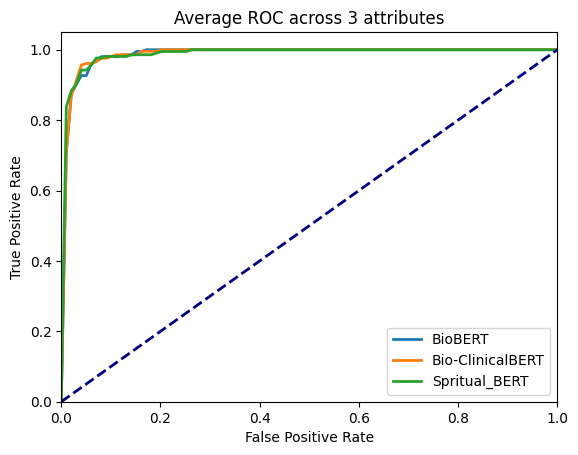

In [18]:
plot_average_roc_curves(test_predictions_dict, test_true_labels_dict, pallative_cares[1:], model_names)


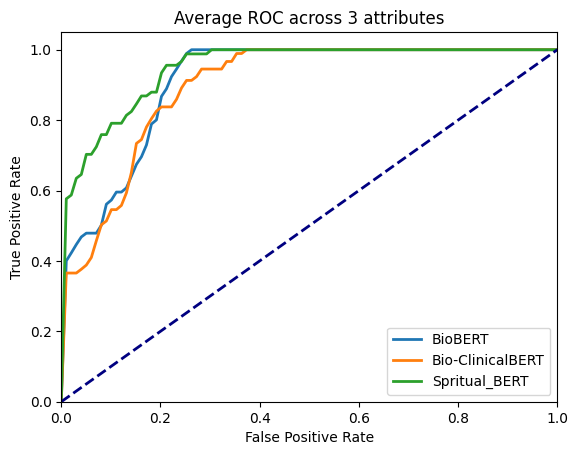

In [19]:
plot_average_roc_curves(external_predictions_dict, external_true_labels_dict, pallative_cares[1:], model_names)

ROC curve and AUC in Test datsset


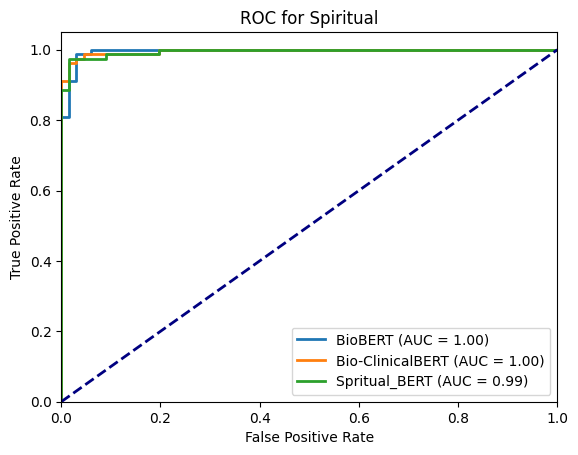

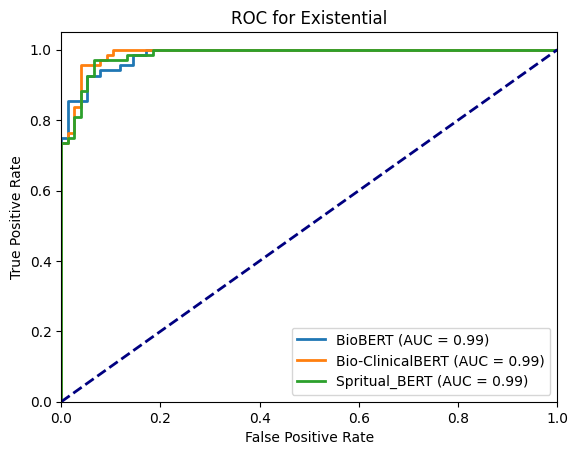

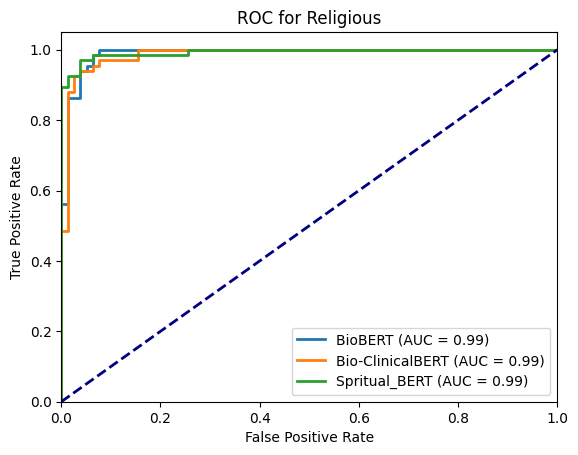

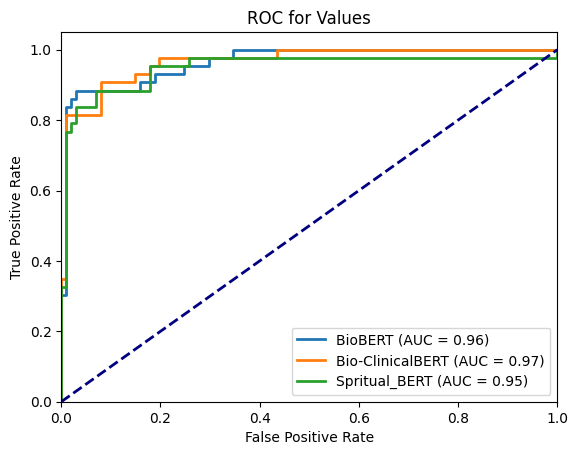

*********************************************************************************************
ROC curve and AUC in External datsset


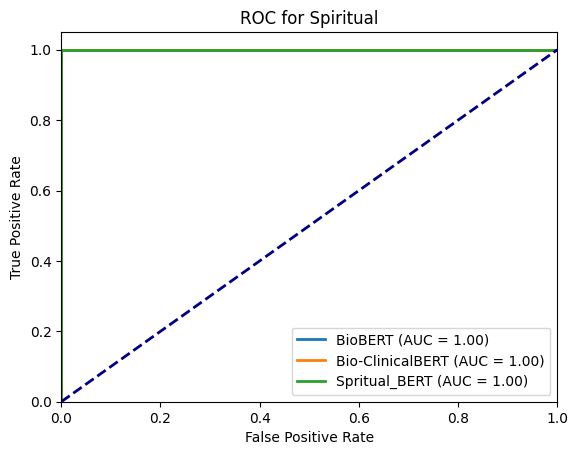

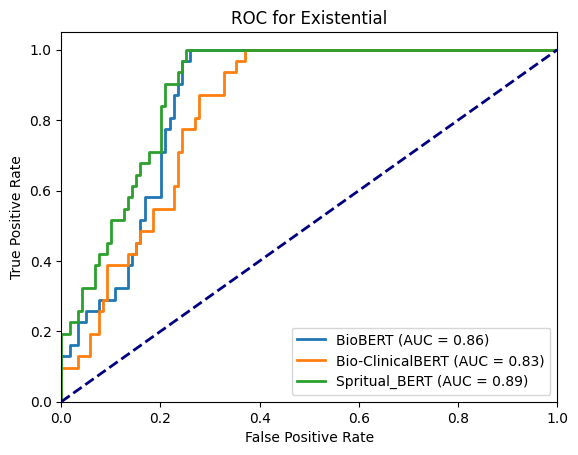

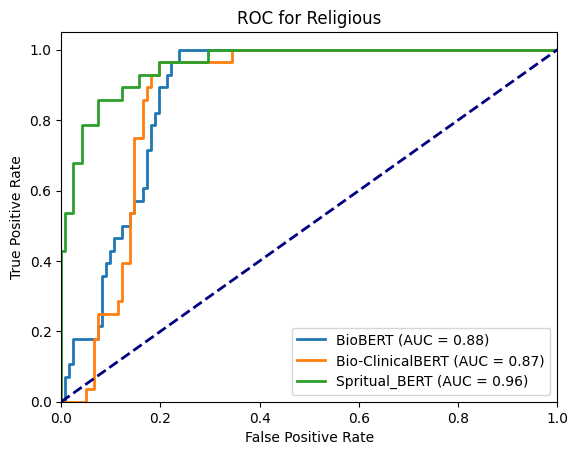

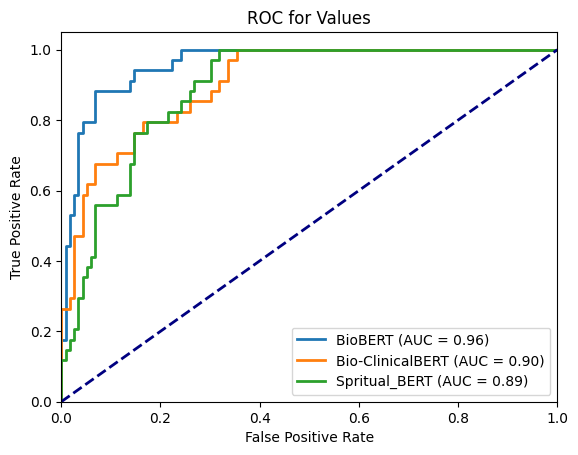

*********************************************************************************************


In [20]:
print("ROC curve and AUC in Test datsset")
plot_roc_curves_for_labels(test_predictions_dict, test_true_labels_dict, pallative_cares, model_names)
print(f"*********************************************************************************************")
print("ROC curve and AUC in External datsset")
plot_roc_curves_for_labels(external_predictions_dict, external_true_labels_dict, pallative_cares, model_names)
print(f"*********************************************************************************************")
    
